In [1]:
# Download coastlines shapefile from: https://www.ngdc.noaa.gov/mgg/shorelines/data/gshhg/latest/
# Cut the domain of interest from the full resolution shapefile
!ogr2ogr -f "ESRI Shapefile" C:/Users/panmits86/Desktop/Python/gshhg-shp-2.3.7/GSHHS_shp/f/GSHHS_f_L1_SNE.shp C:/Users/panmits86/Desktop/Python/gshhg-shp-2.3.7/GSHHS_shp/f/GSHHS_f_L1.shp -clipsrc -74 -70 40 42

In [4]:
from pathlib import Path
import numpy as np
from datetime import datetime
import xarray as xr

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatch
from matplotlib.transforms import offset_copy
import matplotlib.colors as colors
from cartopy.io import shapereader
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.patches as mpatches
import pandas as pd
import glob

import gdal
import cmocean
import cmaps

%matplotlib inline

## SARAL-AltiKa Level 2

Data are divided in two separate phases. The first phase (2013-2016) has been completed. The second phase (what is called the drifting phase) is still in operation.

In [2]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    """
    
    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    

    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [12]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/SA_val_1')

results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh = pd.concat(results)

In [14]:
swh_sa = swh[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa 

,time,lon,lat,swh,wind_speed_alt
0,2014-08-21 23:28:11.270705920,286.247050,40.434171,0.829,5.36
1,2014-08-21 23:28:13.343635072,286.206852,40.312579,0.775,5.10
2,2014-08-21 23:28:14.380099072,286.186796,40.251778,0.814,5.07
3,2014-08-21 23:28:15.416562112,286.166767,40.190975,0.816,4.96
4,2014-08-21 23:28:17.489491008,286.126794,40.069361,0.872,4.90
...,...,...,...,...,...
2144,2016-07-02 23:23:13.374428992,287.123974,40.456116,0.974,4.87
2145,2016-07-02 23:23:14.411950080,287.103842,40.395275,0.909,4.85
2146,2016-07-02 23:23:15.449467904,287.083740,40.334432,0.959,5.27
2147,2016-07-02 23:23:17.524507968,287.043619,40.212736,1.076,6.09


In [15]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

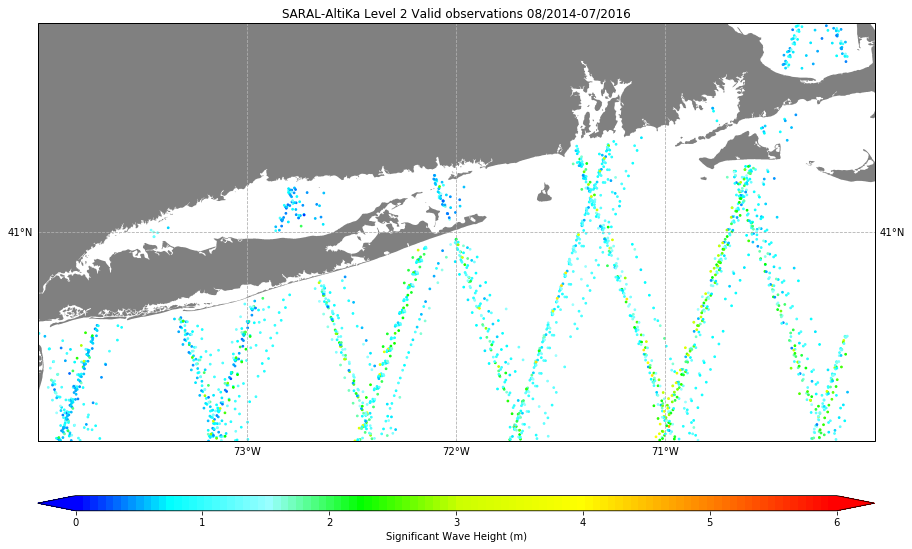

In [16]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['swh'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('SARAL-AltiKa Level 2 Valid observations 08/2014-07/2016')
plt.savefig('SNE_obs_SA_Level2_valid.png', dpi=300, bbox_inches='tight')

In [17]:
# function to remove outliers from every single along track

def remove_outliers(fname):
    
    #read the data files
    df2 = xr.open_dataset(fname)
    
    #select all the required variables to detect only the valid data
    df2 = df2[['swh','swh_rms','surface_type','wind_speed_alt','ice_flag','sig0','off_nadir_angle_wf','sig0_rms','range_rms','swh_numval', \
           'swh_rms']]
    
    # convert to pandas dataframe
    df2 = df2.to_dataframe()
    df2.reset_index(inplace=True)
    
        # apply the filtering criteria
    df2 = df2[(df2['surface_type'] == 0.) & (df2['ice_flag'] == 0.) & (df2['swh'] < 30.) & (df2['sig0'] < 30.) & (df2['sig0'] > 3.) \
            & (df2['off_nadir_angle_wf'] < 0.0625) & (df2['off_nadir_angle_wf'] > -0.2) & (df2['wind_speed_alt'] < 30) & \
             (df2['sig0_rms'] < 1) & (df2['range_rms'] < 0.2) & (df2['swh_numval'] > 20) & (df2['swh_rms'] < df2['swh'])]
    
    
    # remove outliers from significant wave height
    q1 = df2['swh'].quantile(0.25)
    q3 = df2['swh'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    
    outliers_removed = df2.loc[(df2['swh'] > fence_low) & (df2['swh'] < fence_high)]
    
    """
    
    #use the standard deviation method
    
    # calculate summary statistics
    data_mean, data_std = np.mean(df2['swh']), np.std(df2['swh'])
    #identify outliers
    cut_off = data_std * 3
    lower, upper = data_mean - cut_off, data_mean + cut_off
    # remove outliers
    outliers_removed = df2.loc[(df2['swh'] > lower) & (df2['swh'] < upper)]
    

    
    #remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    """

    return outliers_removed

In [18]:
# import all data files
p = Path('C:/Users/panmits86/Desktop/SA_val_2')

results = []
for fname in p.glob('*.nc'):
    swh_sa = remove_outliers(fname)
    results.append(swh_sa)
    swh = pd.concat(results)

In [19]:
swh_sa = swh[['time','lon','lat','swh','wind_speed_alt']]
swh_sa = swh_sa.reset_index()
swh_sa.drop(['index'], axis=1, inplace=True)
swh_sa 

,time,lon,lat,swh,wind_speed_alt
0,2016-07-07 10:14:49.624763008,289.648891,40.191881,1.013,1.13
1,2016-07-07 10:14:52.742073088,289.588603,40.374652,1.090,1.35
2,2016-07-07 10:14:53.781178944,289.568450,40.435571,0.786,1.17
3,2016-07-07 10:14:54.820281984,289.548268,40.496486,0.979,1.23
4,2016-07-07 10:14:55.859388096,289.528058,40.557399,1.097,1.50
...,...,...,...,...,...
5829,2019-12-22 10:22:46.047041920,286.145365,40.025461,0.576,4.69
5830,2019-12-22 10:22:47.084560896,286.125404,40.086325,0.296,4.74
5831,2019-12-22 10:22:48.122082176,286.105414,40.147186,0.407,4.58
5832,2019-12-22 10:22:49.159601152,286.085398,40.208044,0.489,4.26


In [20]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

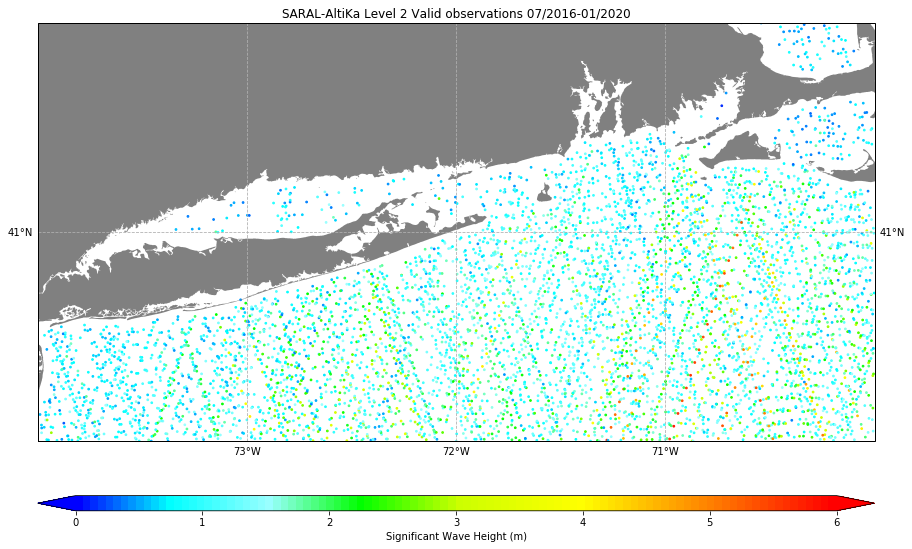

In [21]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_sa['lon'], swh_sa['lat'], c=swh_sa['swh'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('SARAL-AltiKa Level 2 Valid observations 07/2016-01/2020')
plt.savefig('SNE_obs_SA_Level2_valid.png', dpi=300, bbox_inches='tight')

## Jason 3 Level 2 (06/2016-01/2020)

In [23]:
def remove_outliers_ja(fname_ja):
    
    #read the data files
    df4 = xr.open_dataset(fname_ja)
    
    #select all the required variables to detect only the valid data
    df4 = df4[['swh_ku','swh_rms_ku','surface_type','wind_speed_alt','ice_flag','sig0_ku','off_nadir_angle_wf_ku','sig0_rms_ku', \
               'range_rms_ku', 'swh_numval_ku', 'swh_rms_ku']]
    
    # convert to pandas dataframe
    df4 = df4.to_dataframe()
    df4.reset_index(inplace=True)
    
        # apply the filtering criteria
    df4 = df4[(df4['surface_type'] == 0.) & (df4['ice_flag'] == 0.) & (df4['swh_ku'] < 30.) & (df4['sig0_ku'] < 32.38) & \
            (df4['sig0_ku'] > 9.38) & (df4['wind_speed_alt'] > 0.) \
            & (df4['off_nadir_angle_wf_ku'] < 0.64) & (df4['off_nadir_angle_wf_ku'] > -0.2) & (df4['wind_speed_alt'] < 30) & \
             (df4['sig0_rms_ku'] < 2.5) & (df4['range_rms_ku'] < 0.0115*df4['swh_ku'] + 0.2) & (df4['swh_numval_ku'] > 10) & \
            (df4['swh_rms_ku'] < df4['swh_ku'])]
    
    # remove outliers from significant wave height
    q1 = df4['swh_ku'].quantile(0.25)
    q3 = df4['swh_ku'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed_ja = df4.loc[(df4['swh_ku'] > fence_low) & (df4['swh_ku'] < fence_high)]
    
    '''
    # remove outliers from wind speed
    q1 = df2['wind_speed_alt'].quantile(0.25)
    q3 = df2['wind_speed_alt'].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    outliers_removed = df2.loc[(df2['wind_speed_alt'] > fence_low) & (df2['wind_speed_alt'] < fence_high)]
    
    '''
    
    return outliers_removed_ja

In [24]:
# import all data files
pp = Path('C:/Users/panmits86/Desktop/J3_val')

results = []
for fname_ja in pp.glob('*.nc'):
    swh_ja = remove_outliers_ja(fname_ja)
    results.append(swh_ja)
    swh_j = pd.concat(results)

In [25]:
swh_ja = swh_j[['time','lon','lat','swh_ku','wind_speed_alt']]
swh_ja = swh_ja.reset_index()
swh_ja.drop(['index'], axis=1, inplace=True)
swh_ja

,time,lon,lat,swh_ku,wind_speed_alt
0,2016-06-27 06:18:09.679733056,286.740002,40.581447,1.100,1.88
1,2016-06-27 06:18:10.698442944,286.773812,40.535419,0.933,4.21
2,2016-06-27 06:18:11.717152128,286.807570,40.489377,1.061,4.89
3,2016-06-27 06:18:12.735862976,286.841276,40.443323,0.899,4.46
4,2016-06-27 06:18:13.754571904,286.874931,40.397256,1.003,4.53
...,...,...,...,...,...
9196,2016-06-24 21:37:29.572333120,289.082444,41.099596,0.796,4.22
9197,2016-06-24 21:37:30.591042048,289.116904,41.145459,0.535,4.13
9198,2016-06-24 21:37:31.609752896,289.151417,41.191308,0.882,3.38
9199,2016-06-24 21:37:44.852983936,289.605067,41.786108,0.909,3.03


In [26]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

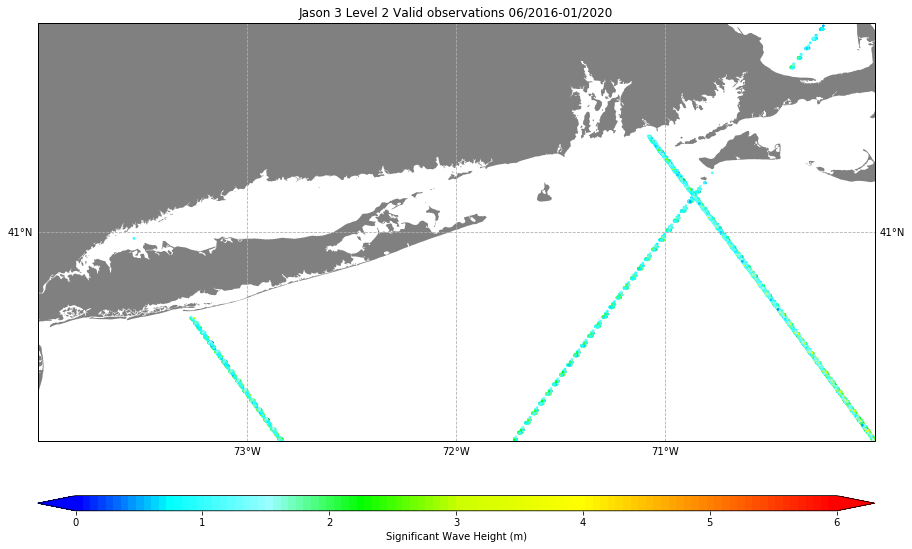

In [28]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=6)
cs2 = plt.scatter(swh_ja['lon'], swh_ja['lat'], c=swh_ja['swh_ku'], s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('Jason 3 Level 2 Valid observations 06/2016-01/2020')
plt.savefig('SNE_obs_J3_Level2_valid.png', dpi=300, bbox_inches='tight')

## CMEMS LeveL 3 observations

Currently, there are 6 satellite altimeters in operation (SARAL-AltiKa, Jason 3, Cryosat 2, CFOSAT, Sentinel 3A & 3B). Level 3 is a new, along-track product for Significant Wave Height from CMEMS. 

More info: https://resources.marine.copernicus.eu/?option=com_csw&task=results?option=com_csw&view=details&product_id=WAVE_GLO_WAV_L3_SWH_NRT_OBSERVATIONS_014_001

In [29]:
ds10 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/SA_L3/global_vavh_l3_rt_al_20*.nc')
wh_cmems = ds10['VAVH']
wh_cmems

<ipython-input-29-4e6d7cabc216>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds10 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/SA_L3/global_vavh_l3_rt_al_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


,Array,Chunk
Bytes,17.04 MB,28.48 kB
Shape,"(4258967,)","(7121,)"
Count,2700 Tasks,900 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,34.07 MB,56.97 kB
Shape,"(4258967,)","(7121,)"
Count,2700 Tasks,900 Chunks
Type,float64,numpy.ndarray
,Array,Chunk


In [30]:
def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(15, 20),
                           subplot_kw=dict(projection=projection))
    gl = ax.gridlines(draw_labels=True, linestyle='--')
    gl.xlabels_top = False
    gl.xlocator = mticker.FixedLocator([-74, -73, -72, -71, -70])
    gl.ylocator = mticker.FixedLocator([40, 41, 42])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

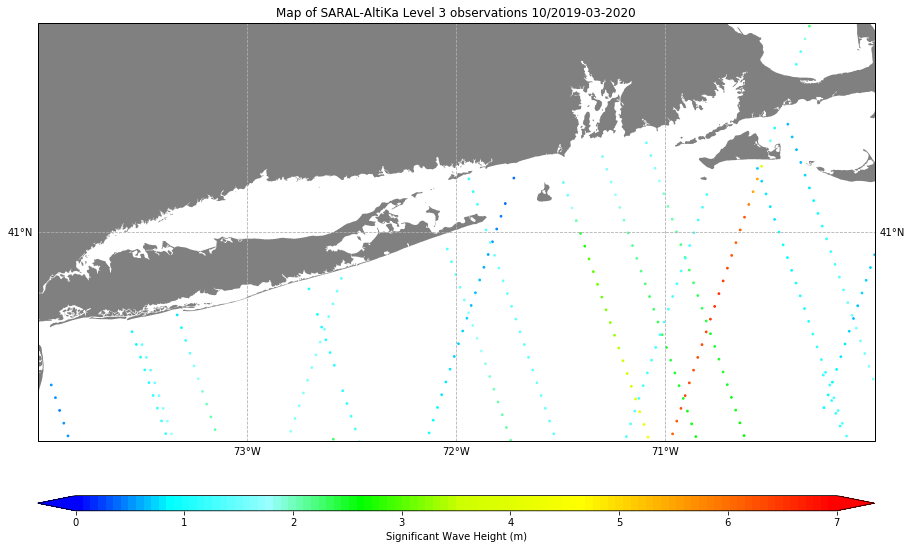

In [31]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems['longitude'], wh_cmems['latitude'], c=wh_cmems, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('Map of SARAL-AltiKa Level 3 observations 10/2019-03-2020')
#ax.add_patch(mpatches.Circle(xy=[lon, lat], radius=r_ortho, color='red', alpha=0.1, transform=proj, zorder=30))
plt.savefig('SNE_obs_SA_cmems.png', dpi=300, bbox_inches='tight')

In [7]:
ds11 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/J3_L3/global_vavh_l3_rt_j3_20*.nc')
wh_cmems_j3 = ds11['VAVH']
wh_cmems_j3

<ipython-input-7-2775a50eed69>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds11 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/J3_L3/global_vavh_l3_rt_j3_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


<xarray.DataArray 'VAVH' (time: 6049119)>
dask.array<concatenate, shape=(6049119,), dtype=float32, chunksize=(8803,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01T00:00:01.016549120 ... 2020-03-10T18:12:08.070915200
    latitude   (time) float64 dask.array<chunksize=(6699,), meta=np.ndarray>
    longitude  (time) float64 dask.array<chunksize=(6699,), meta=np.ndarray>
Attributes:
    comment:        Bias corrected and filtered. Calibration relative to buoy...
    valid_min:      0
    long_name:      Significant Wave Height on main altimeter frequency band
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_max:      32767

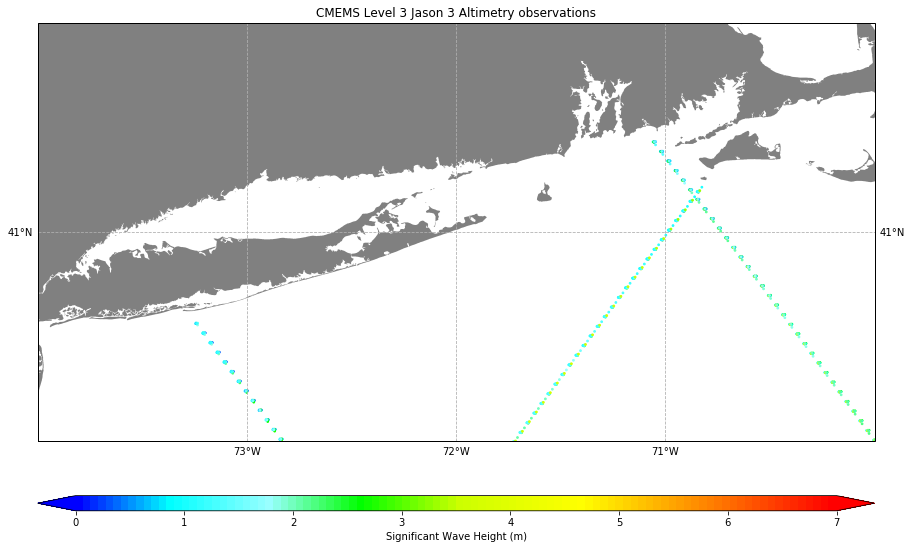

In [8]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems_j3['longitude'], wh_cmems_j3['latitude'], c=wh_cmems_j3, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('CMEMS Level 3 Jason 3 Altimetry observations')
plt.savefig('SNE_obs_J3_cmems.png', dpi=300, bbox_inches='tight')

In [9]:
ds12 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/C2_L3/global_vavh_l3_rt_c2_20*.nc')
wh_cmems_c2 = ds12['VAVH']
wh_cmems_c2

<ipython-input-9-02988592ce2c>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds12 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/C2_L3/global_vavh_l3_rt_c2_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


<xarray.DataArray 'VAVH' (time: 5355339)>
dask.array<concatenate, shape=(5355339,), dtype=float32, chunksize=(7953,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01T00:07:47.019298048 ... 2020-03-11T00:05:40.797319936
    latitude   (time) float64 dask.array<chunksize=(5783,), meta=np.ndarray>
    longitude  (time) float64 dask.array<chunksize=(5783,), meta=np.ndarray>
Attributes:
    comment:        Bias corrected and filtered. Calibration relative to buoy...
    valid_min:      0
    long_name:      Significant Wave Height on main altimeter frequency band
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_max:      32767

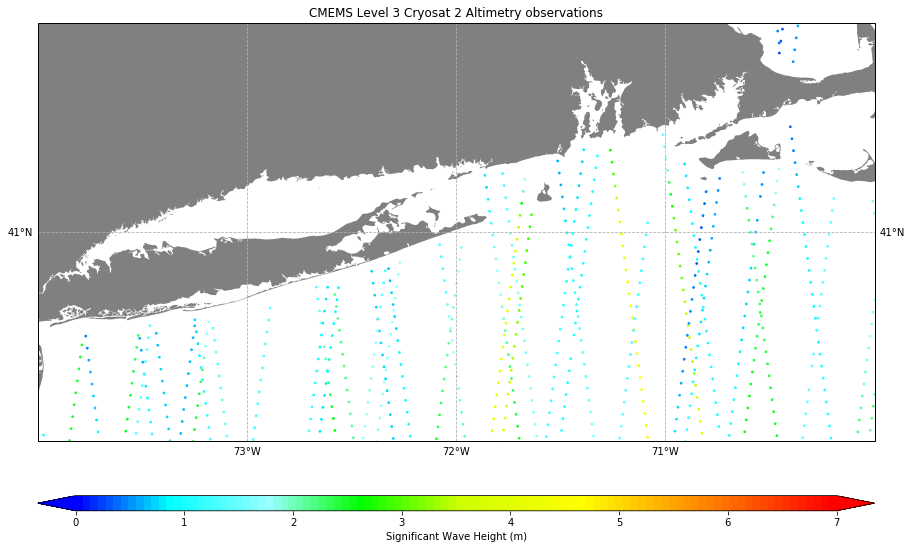

In [10]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems_c2['longitude'], wh_cmems_c2['latitude'], c=wh_cmems_c2, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('CMEMS Level 3 Cryosat 2 Altimetry observations')
plt.savefig('SNE_obs_C2_cmems.png', dpi=300, bbox_inches='tight')

In [11]:
ds13 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/CFO_L3/global_vavh_l3_rt_cfo_20*.nc')
wh_cmems_cfo = ds13['VAVH']
wh_cmems_cfo

<ipython-input-11-817824c923ac>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds13 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/CFO_L3/global_vavh_l3_rt_cfo_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


<xarray.DataArray 'VAVH' (time: 8019711)>
dask.array<concatenate, shape=(8019711,), dtype=float32, chunksize=(7671,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2019-07-16T05:37:05 ... 2020-03-11T00:49:04
    latitude   (time) float64 dask.array<chunksize=(391,), meta=np.ndarray>
    longitude  (time) float64 dask.array<chunksize=(391,), meta=np.ndarray>
Attributes:
    comment:        Bias corrected and filtered. Calibration relative to buoy...
    valid_min:      0
    long_name:      Significant Wave Height on main altimeter frequency band
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_max:      32767

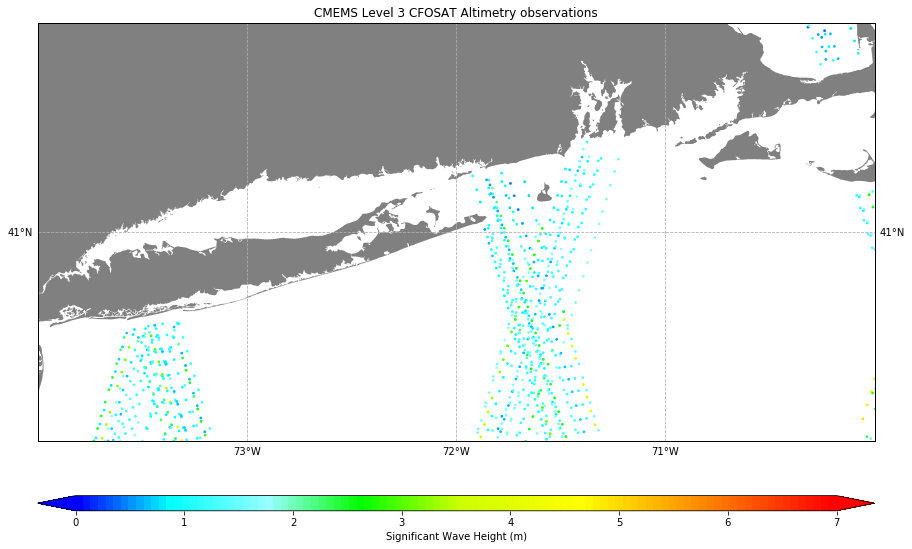

In [12]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems_cfo['longitude'], wh_cmems_cfo['latitude'], c=wh_cmems_cfo, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('CMEMS Level 3 CFOSAT Altimetry observations')
plt.savefig('SNE_obs_CFO_cmems.png', dpi=300, bbox_inches='tight')

In [13]:
ds14 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/S3A_L3/global_vavh_l3_rt_s3a_20*.nc')
wh_cmems_s3a = ds14['VAVH']
wh_cmems_s3a

<ipython-input-13-254b4eec22e8>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds14 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/S3A_L3/global_vavh_l3_rt_s3a_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


<xarray.DataArray 'VAVH' (time: 5765741)>
dask.array<concatenate, shape=(5765741,), dtype=float32, chunksize=(7989,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01T00:00:01 ... 2020-03-11T02:43:38
    latitude   (time) float64 dask.array<chunksize=(4825,), meta=np.ndarray>
    longitude  (time) float64 dask.array<chunksize=(4825,), meta=np.ndarray>
Attributes:
    comment:        Bias corrected and filtered. Calibration relative to buoy...
    valid_min:      0
    long_name:      Significant Wave Height on main altimeter frequency band
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_max:      32767

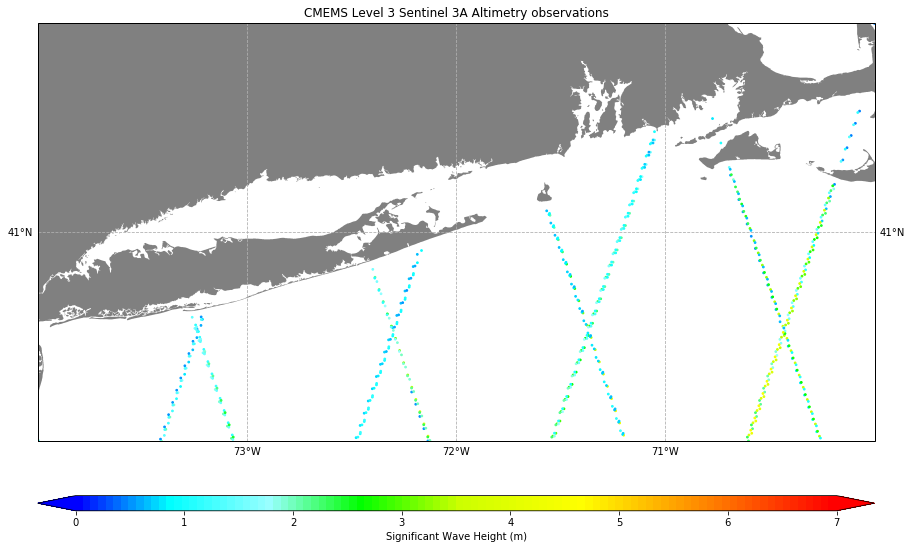

In [14]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations.
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems_s3a['longitude'], wh_cmems_s3a['latitude'], c=wh_cmems_s3a, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('CMEMS Level 3 Sentinel 3A Altimetry observations')
plt.savefig('SNE_obs_S3A_cmems.png', dpi=300, bbox_inches='tight')

In [15]:
ds15 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/S3B_L3/global_vavh_l3_rt_s3b_20*.nc')
wh_cmems_s3b = ds15['VAVH']
wh_cmems_s3b

<ipython-input-15-a612a612bdd7>:1: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds15 = xr.open_mfdataset('C:/Users/panmits86/Desktop/Python/data/CMEMS_LEVEL_3/S3B_L3/global_vavh_l3_rt_s3b_20*.nc')
C:\Users\panmits86\Anaconda3\envs\thesis\lib\site-packages\xarray\backends\api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(


<xarray.DataArray 'VAVH' (time: 5529372)>
dask.array<concatenate, shape=(5529372,), dtype=float32, chunksize=(8006,), chunktype=numpy.ndarray>
Coordinates:
  * time       (time) datetime64[ns] 2019-10-01 ... 2020-03-11T02:34:29
    latitude   (time) float64 dask.array<chunksize=(6094,), meta=np.ndarray>
    longitude  (time) float64 dask.array<chunksize=(6094,), meta=np.ndarray>
Attributes:
    comment:        Bias corrected and filtered. Calibration relative to buoy...
    valid_min:      0
    long_name:      Significant Wave Height on main altimeter frequency band
    standard_name:  sea_surface_wave_significant_height
    units:          m
    valid_max:      32767

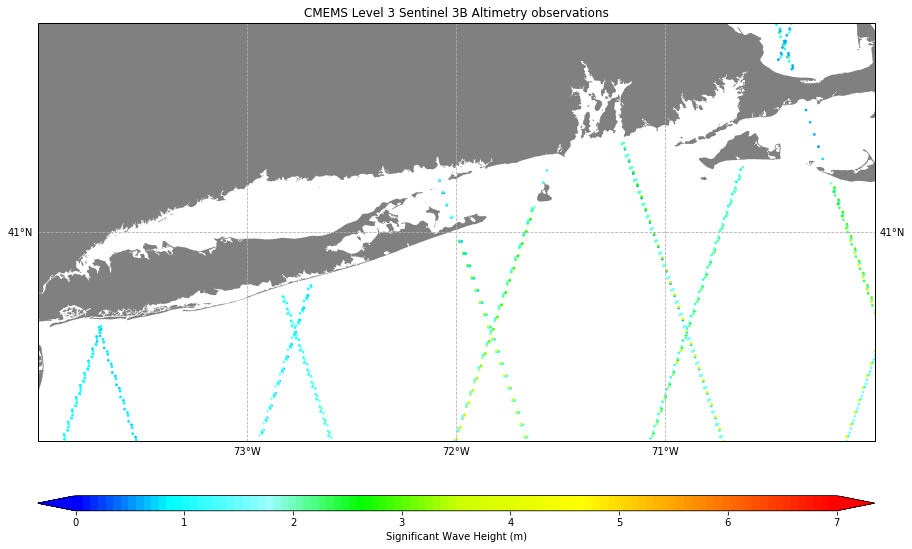

In [16]:
fig, ax = make_map(projection=ccrs.PlateCarree())
ax.set_extent([-74, -70, 40, 42])

shp = shapereader.Reader('C:/Users/panmits86/Desktop/Python/SNE_shapefile/GSHHS_f_L1_SNE.shp')
for record, geometry in zip(shp.records(), shp.geometries()):
    ax.add_geometries([geometry], ccrs.PlateCarree(), facecolor='gray')

# Add markers for the position of the satellite observations 
cmap=cmaps.BlAqGrYeOrRe
bounds = np.array([0,1,2,3,4,5,6,7])
#norm = colors.BoundaryNorm(boundaries=bounds, ncolors=10)
norm = mpl.colors.Normalize(vmin=0, vmax=7)
cs2 = plt.scatter(wh_cmems_s3b['longitude'], wh_cmems_s3b['latitude'], c=wh_cmems_s3b, s=3, marker='o', cmap=cmap, norm=norm,
            transform=ccrs.Geodetic())
cax,kw = matplotlib.colorbar.make_axes(ax,location='bottom',pad=0.05,aspect=50)
out=fig.colorbar(cs2,cax=cax,ticks=bounds,extend='both',**kw)
out.set_label('Significant Wave Height (m)',size=10)
ax.set_title('CMEMS Level 3 Sentinel 3B Altimetry observations')
plt.savefig('SNE_obs_S3B_cmems.png', dpi=300, bbox_inches='tight')